# CNN - Rock Paper Scissors images from various hands, from different races, ages and genders, posed into Rock / Paper or Scissors and labelled as such

## Library Imports

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(f"Using Tensorflow version - {tf.__version__}")

Using Tensorflow version - 2.9.1


In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the Image Data

In [3]:
DATASET_DIR = os.environ.get('DATASET_DIR')
PARENT_DIR = os.path.join(DATASET_DIR, 'rock-paper-scissors')

# Directory for training images
TRAIN_DIR = os.path.join(PARENT_DIR, 'rps-train')
TRAIN_PAPER_DIR = os.path.join(TRAIN_DIR, 'paper')
TRAIN_ROCKS_DIR = os.path.join(TRAIN_DIR, 'rock')
TRAIN_SCISSORS_DIR = os.path.join(TRAIN_DIR, 'scissors')

# Directory for validation images
VALIDATION_DIR = os.path.join(PARENT_DIR, 'rps-validation')
VALIDATION_PAPER_DIR = os.path.join(VALIDATION_DIR, 'paper')
VALIDATION_ROCKS_DIR = os.path.join(VALIDATION_DIR, 'rock')
VALIDATION_SCISSORS_DIR = os.path.join(VALIDATION_DIR, 'scissors')

# We will check the first five image names of cats and dogs
train_paper_fnames = os.listdir(TRAIN_PAPER_DIR)
print(f"Five file names of paper images training - {train_paper_fnames[:5]}")
train_rocks_fnames = os.listdir(TRAIN_ROCKS_DIR)
print(f"Five file names of rock images training - {train_rocks_fnames[:5]}")
train_scissor_fnames = os.listdir(TRAIN_SCISSORS_DIR)
print(f"Five file names of scissor images training - {train_scissor_fnames[:5]}")


# Check the total number of images available for each classes for training avd validation
print(f"Total number of paper images available for training - {len(os.listdir(TRAIN_PAPER_DIR))}")
print(f"Total number of rock images available for training - {len(os.listdir(TRAIN_ROCKS_DIR))}")
print(f"Total number of scissor images available for training - {len(os.listdir(TRAIN_SCISSORS_DIR))}")

print(f"Total Number of paper images available for validation - {len(os.listdir(VALIDATION_PAPER_DIR))}")
print(f"Total Number of rocks images available for validation - {len(os.listdir(VALIDATION_ROCKS_DIR))}")
print(f"Total Number of scissor images available for validation - {len(os.listdir(VALIDATION_SCISSORS_DIR))}")

Five file names of paper images training - ['paper01-005.png', 'paper01-006.png', 'paper01-007.png', 'paper01-008.png', 'paper01-009.png']
Five file names of rock images training - ['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png']
Five file names of scissor images training - ['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png']
Total number of paper images available for training - 835
Total number of rock images available for training - 840
Total number of scissor images available for training - 840
Total Number of paper images available for validation - 124
Total Number of rocks images available for validation - 124
Total Number of scissor images available for validation - 124


## Some Image Visualizations

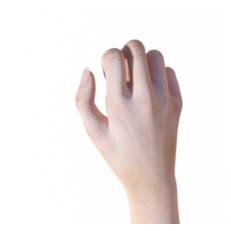

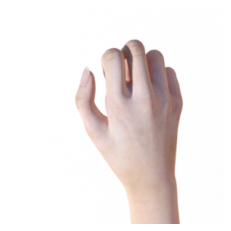

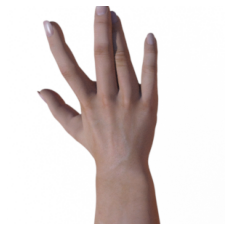

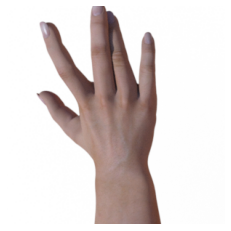

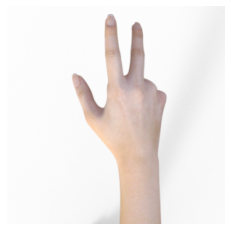

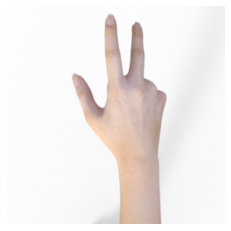

In [4]:
pic_index = 2  # Visualize two images from each of the classes

next_rock = [os.path.join(TRAIN_ROCKS_DIR, fname) for fname in os.listdir(TRAIN_ROCKS_DIR)[pic_index-2:pic_index]]
next_paper = [os.path.join(TRAIN_PAPER_DIR, fname) for fname in os.listdir(TRAIN_PAPER_DIR)[pic_index-2:pic_index]]
next_scissor = [os.path.join(TRAIN_SCISSORS_DIR, fname) for fname in os.listdir(TRAIN_SCISSORS_DIR)[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissor):
    img = mpimage.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

## Image Processing for Modelling

In [5]:
# All images will be rescaled to 1/255
# Also image augmentation techniques will be applied to reduce overfitting

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255.0) # We will not apply image augmentation in validation set

In [6]:
training_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(150, 150), class_mode='categorical', batch_size=125)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(150, 150), class_mode='categorical', batch_size=93)

Found 2515 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## Build and Train the CNN model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.keras.activations.relu, input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=3, activation=tf.keras.activations.softmax)
])

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [8]:
# Train the model
epochs_history = model.fit(training_generator, steps_per_epoch=20, epochs=10, validation_data=validation_generator, validation_steps=3, verbose=1)

Epoch 1/10
20/20 [==============================] - 18s 748ms/step - loss: 1.1246 - accuracy: 0.3833 - val_loss: 1.0820 - val_accuracy: 0.3190
Epoch 2/10
20/20 [==============================] - 15s 758ms/step - loss: 1.0172 - accuracy: 0.4766 - val_loss: 0.8513 - val_accuracy: 0.6738
Epoch 3/10
20/20 [==============================] - 15s 756ms/step - loss: 0.7754 - accuracy: 0.6427 - val_loss: 0.4234 - val_accuracy: 0.8889
Epoch 4/10
20/20 [==============================] - 15s 755ms/step - loss: 0.5888 - accuracy: 0.7527 - val_loss: 0.3619 - val_accuracy: 0.8100
Epoch 5/10
20/20 [==============================] - 15s 760ms/step - loss: 0.4265 - accuracy: 0.8406 - val_loss: 0.1348 - val_accuracy: 0.9498
Epoch 6/10
20/20 [==============================] - 15s 752ms/step - loss: 0.3649 - accuracy: 0.8665 - val_loss: 0.1833 - val_accuracy: 0.9391
Epoch 7/10
20/20 [==============================] - 15s 759ms/step - loss: 0.2697 - accuracy: 0.9105 - val_loss: 0.1783 - val_accuracy: 0.9211

## Evaluating Accuracy and Loss for the Model

In [10]:
acc = epochs_history.history['accuracy']
val_acc = epochs_history.history['val_accuracy']
loss = epochs_history.history['loss']
val_loss = epochs_history.history['val_loss']

# Getting the number of epochs
epochs = range(len(acc))

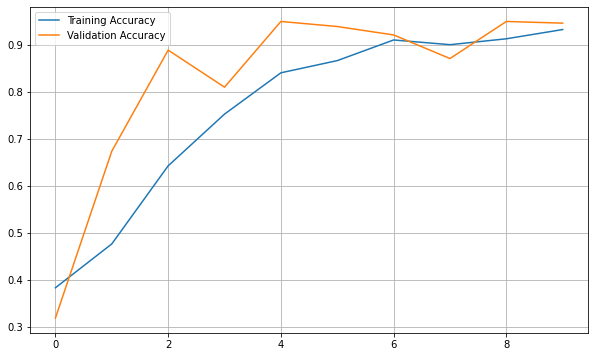

In [11]:
# Plot training and Validation accuracy by epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.legend()
plt.grid(True)

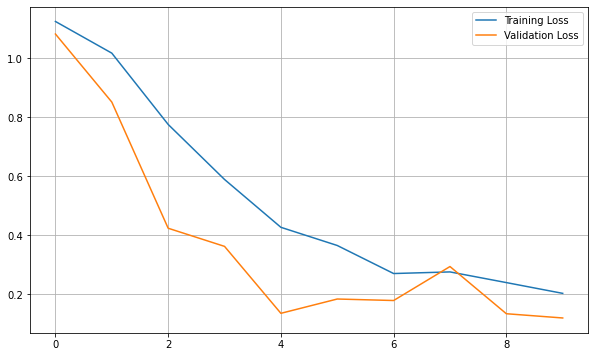

In [12]:
# Plot training and Validation Loss by epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.grid(True)

## Prediction on Test Images

In [17]:
from tensorflow.keras.preprocessing import image

TEST_DIR = os.path.join(PARENT_DIR,'rps-test')
images = os.listdir(TEST_DIR)

for index in images:
    print() # a blank space
    path = os.path.join(TEST_DIR, index)
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(path)
    print(classes)


1/1 [==============================] - 0s 329ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper-hires1.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 18ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper-hires2.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 16ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper1.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 17ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper2.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 20ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper3.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 17ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper4.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 17ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper5.png
[[0. 0. 1.]]

1/1 [==============================] - 0s 24ms/step
D:\Datasets\rock-paper-scissors\rps-test\paper6.png
[[1. 0. 0.]]

1/1 [==============================] - 0s 